# Muilti-grid Fluid

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/Multi_Grid_Fluid.ipynb)

This example uses a low-resolution and embedded high-resolution grid in conjunction to run a fluid simulation.

In [ ]:
%pip install phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

Let's start by defining our geometries. We simulate the fluid on a large domain and around the obstacle on a smaller domain with higher resolution.
We place a smoke inflow at the bottomm.

<Figure size 864x360 with 1 Axes>

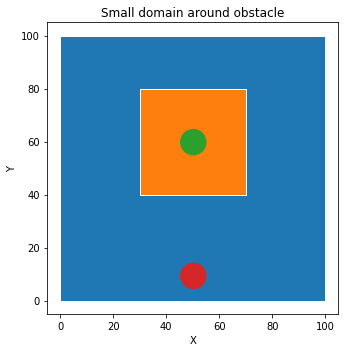

In [2]:
large_domain = Box(x=100, y=100)
small_domain = Box(x=(30, 70), y=(40, 80))
obstacle = Sphere(x=50, y=60, radius=5)
inflow = Sphere(x=50, y=9.5, radius=5)
inflow_rate = 0.2

plot(large_domain, small_domain, obstacle, inflow, overlay='args', title="Small domain around obstacle")

We initialize the velocity and smoke density to 0.
We use a $32\times32$ grid for the large velocity grid, a $64\times64$ grid for the small velocity grid, and a $200\times200$ grid for the smoke density.

In [ ]:
v0_large = StaggeredGrid(0, 0, large_domain, x=32, y=32)
v0_small = v0_large.at(StaggeredGrid(0, boundary=v0_large, bounds=small_domain, x=64, y=64))
smoke = CenteredGrid(0, ZERO_GRADIENT, large_domain, x=200, y=200)

Now we're ready to define the simulation step.
We need to advect the smoke and apply the buoyancy force to both small and large velocity grids.
Then we simulate advection on both grids, recording the pressure from the large grid.
This pressure can now be used as the boundary condition for the pressure solve on the small grid.

In [3]:
@jit_compile
def step(v, v_small, s, p, dt=1.):
    s = advect.mac_cormack(s, v_small, dt) + inflow_rate * resample(inflow, s, soft=True)
    buoyancy = s * (0, 0.1)
    v_small = advect.semi_lagrangian(v_small, v_small, dt) + buoyancy.at(v_small) * dt
    v = advect.semi_lagrangian(v, v, dt) + buoyancy.at(v) * dt
    v, p = fluid.make_incompressible(v, [obstacle], Solve(x0=p))
    # --- Small domain pressure solve ---
    p_emb_x0 = CenteredGrid(0, p, v_small.bounds, v_small.resolution)
    v_small = StaggeredGrid(v_small, ZERO_GRADIENT, v_small.bounds, v_small.resolution)
    v_small, p_emb = fluid.make_incompressible(v_small, [obstacle], Solve('auto', 1e-5, 1e-5, x0=p_emb_x0))
    v_small = StaggeredGrid(v_small, v, v_small.bounds, v_small.resolution)
    return v, v_small, s, p

In [5]:
v_large_trj, v_small_trj, s_trj, p_trj = iterate(step, batch(time=200), v0_large, v0_small, smoke, None, range=trange)

  0%|          | 0/200 [00:00<?, ?it/s]

Let's plot the simulation! We show the smoke density on the left and the velocity around the obstacle on the right.

In [8]:
plot([obstacle, inflow, s_trj], [obstacle, v_small_trj], overlay='list', animate='time')

<Figure size 864x360 with 1 Axes>

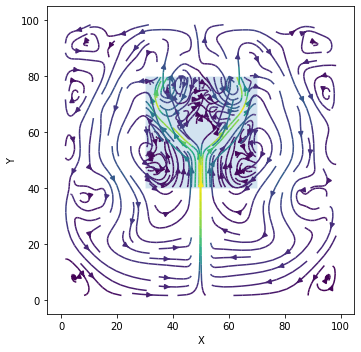

In [14]:
plot([small_domain, v_small_trj.time[-1], v_large_trj.time[-1]],  overlay='list', alpha=[.2, 1, 1])